In [6]:
# This is the template for the submission. You can develop your algorithm in a regular Python script and copy the code here for submission.

# TEAM NAME ON KAGGLE
# "EXAMPLE_GROUP"

# GROUP NUMBER
# "group_XX"

# TEAM MEMBERS (E-MAIL, LEGI, KAGGLE USERNAME):
# "examplestudent1@ethz.ch", "12-345-678", "eXampl3stdNtone" 
# "examplestudent2@ethz.ch", "12-345-679", "xXexamplestudent2Xx"
# "examplestudent3@ethz.ch", "12-345-670", "mhealth_student_98"

## import librtrays



In [7]:
%matplotlib inline

from os import listdir
from os.path import isfile, join
import re
from mhealth_activity import Recording, Trace 

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import silhouette_samples


import xgboost as xgb
from sklearn.metrics import pairwise_distances
import seaborn

import matplotlib.pyplot as plt
import scipy.signal as scs

import matplotlib.cm as cm


## Define functions and variables


In [24]:
#relevant columns
cols=["ax","ay","az","gx","gy","gz","phone_ax","phone_ay","phone_az"]

#Dimencionality reduccion 
cols_reduccion=["ax","ay"]

dir_traces_test = '/kaggle/input/24-exercise2/data/test'
dir_traces_train = '/kaggle/input/24-exercise2/data/train'
dir_traces_example = '/kaggle/input/24-exercise2/data/example'

# Windows variable
windows_size=20
windows_start=0
windows_end=windows_start+windows_size

#kmeans groups 3 because we want to detect 3 position in the body
num_clusters = 3  

labels = [0,1,2]# (0: left wrist, 1: belt/waistband, 2: right ankle)

def butter(f_s):
    # cut_off frequency
    cut_off = 10
    cut_off_ny = cut_off / (f_s / 2)
    b, a = scs.butter(2, cut_off_ny, btype='lowpass', fs=f_s)
    return b, a

def cleardata(value):
    f_s= value.samplerate
    dt = 1 / f_s
    total_samples = value.samplerate*value.total_time
    delta_v = int(total_samples * value.max_update_gap)
    aceleration=delta_v / value.total_time
    return aceleration

def calibrate(center):
    new=[sum(center[0]),sum(center[1]),sum(center[2])]
    print(new)

    if new[0]<new[1]<new[2]:
        transcription={0:0,1:1,2:2}
        print("case1")
    elif new[0]<new[2] <new[1]:
        transcription={0:0,1:2,2:1}
        print("case2")
    elif new[1]<new[0] <new[2]:
        transcription={0:1,1:0,2:2}
        print("case3")
    elif new[1]<new[2] <new[0]:
        transcription={0:2,1:0,2:1}
        print("case4")
    elif new[2]<new[1] <new[0]:
        transcription={0:2,1:1,2:0}
        print("case5")
    elif new[2]<new[0] <new[1]:
        transcription={0:1,1:2,2:0}
        print("case6")
    return transcription
def files2dataframe(filenames,cols=["ax","ay","az","gx","gy","gz","phone_ax","phone_ay","phone_az"],printbool=False,sample_comlumn=False):

    filedata=[]
    data_list = {}
    recordingOne=None
    for filename in range(len(filenames)):
        
        recording = Recording(filenames[filename])
        data = recording.data
        #filedata.append(data)
        if printbool:
            print(data)
        if filename==0:
            recordingOne=data  
    #for file in filedata:
        for key, value in data.items():
            if key in list(data_list.keys()) and key in cols:
                cl_val=cleardata(value)
                data_list[key].append(cl_val)
                
                if key=="ax" and sample_comlumn:
                    data_list["samplerate"].append(value.samplerate)
                    
                if printbool:
                    print(cl_val)
            elif key in cols:
                data_list[key] = []
                cl_val=cleardata(value)
                data_list[key].append(cl_val)
                
                if key=="ax" and sample_comlumn:
                    data_list["samplerate"] = []
                    data_list["samplerate"].append(value.samplerate)
                if printbool:
                    print(cl_val)

    df = pd.DataFrame(data_list)
    return df

def data2dataframe(dir_traces,windows_start,windows_end,printbool=False,cols=["ax","ay","az","gx","gy","gz","phone_ax","phone_ay","phone_az"],sample_comlumn=False):
    filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
    filenames.sort()
    if printbool:
        print(filenames)

    return files2dataframe(filenames[windows_start:windows_end],cols=cols,printbool=printbool,sample_comlumn=sample_comlumn)




# Machine learning proccess and data vizualisation

print data set for train
            gx          gz          ax      phone_az          az          gy  \
0     3.754655    4.556537    4.356494     18.091076    8.936968    4.530890   
1     6.757108   19.974605    5.982555      6.953637   34.542754    4.504739   
2     4.499099    4.499099   30.588148     75.328343    5.300285    4.874444   
3     3.650667    4.499347   10.001328     44.470018    5.513528    3.675685   
4     4.535978    3.485524    4.448040     11.487839    4.686271    3.773319   
5     4.495726    4.495726   29.545345      9.967828   50.831519    3.971525   
6     3.247034    3.922181   12.367845      9.966855    3.922181    3.322988   
7     6.120228    5.507397    8.568319     24.794604    7.244022   11.016411   
8     2.999373    3.049390   20.407074      5.992077    5.685304    3.049390   
9    93.447050   93.447050   93.447050   3007.442729   93.447050   93.447050   
10    6.738116    6.738116   82.165825     58.327059    6.912471    6.738116   
11    6.731473 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


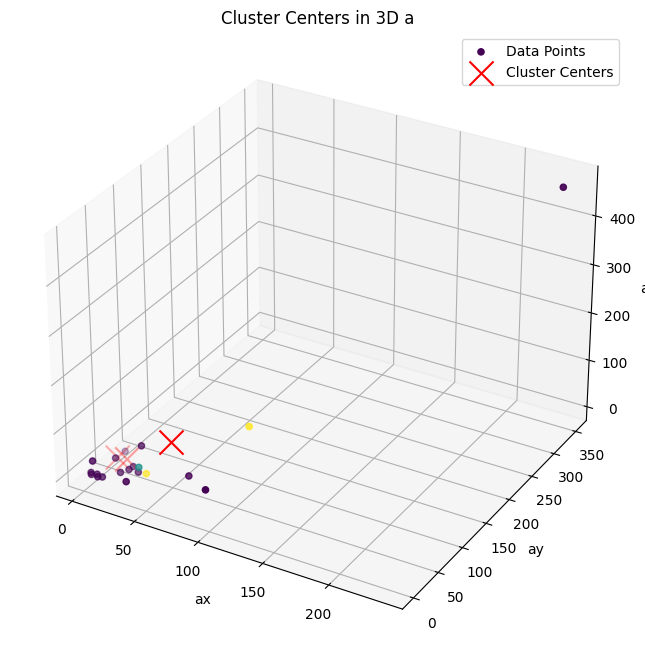

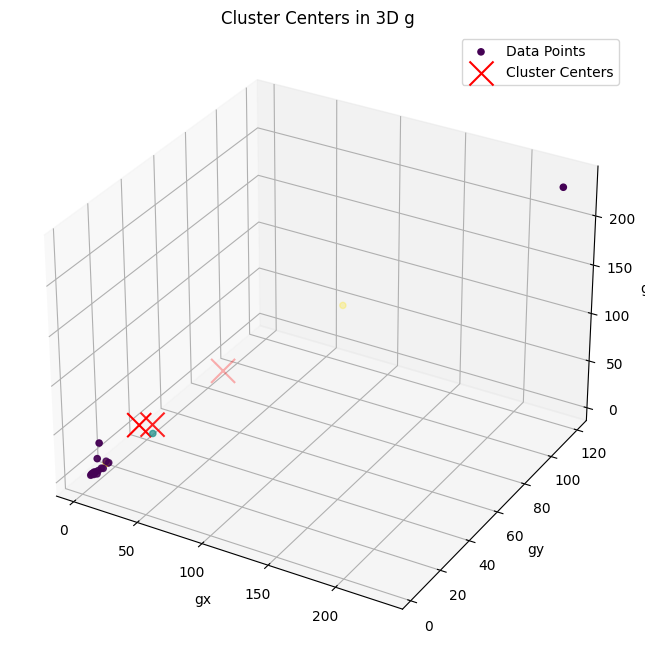

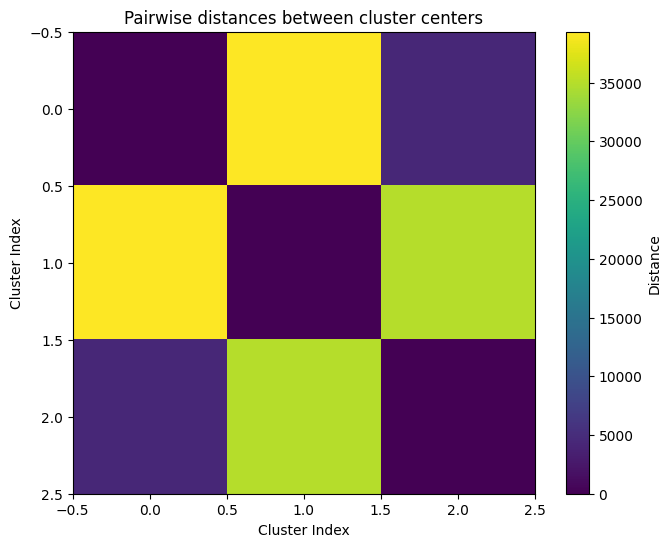

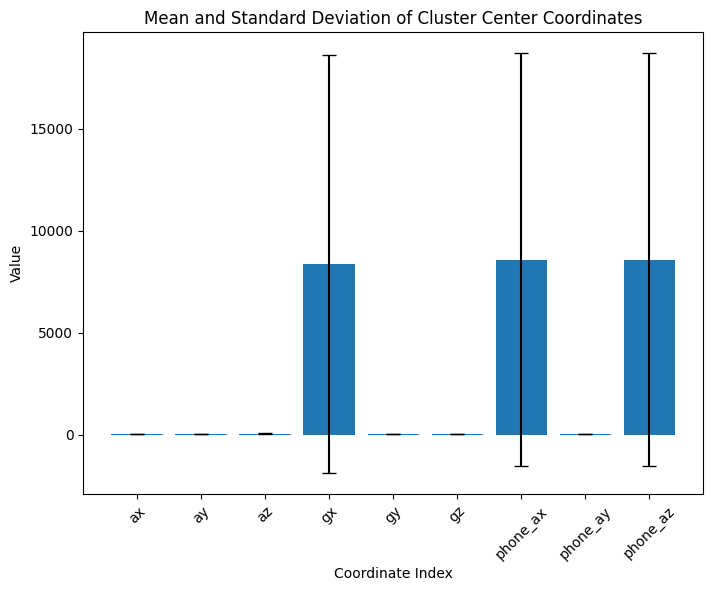

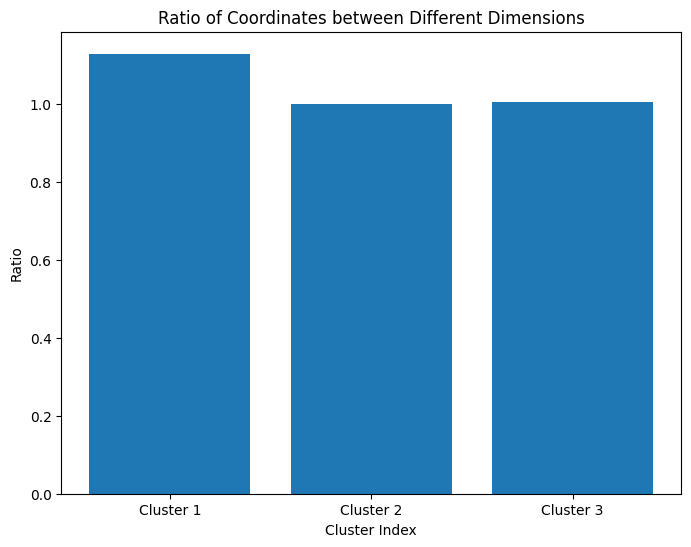

[0.06690025 0.03441344 0.06636155 0.08345517 0.06181362 0.06368989
 0.08161287 0.46713163 0.07462157] [0.05330111 0.0084222  0.03803529 0.12225939 0.00960495 0.00789151
 0.         0.7604856  0.        ]


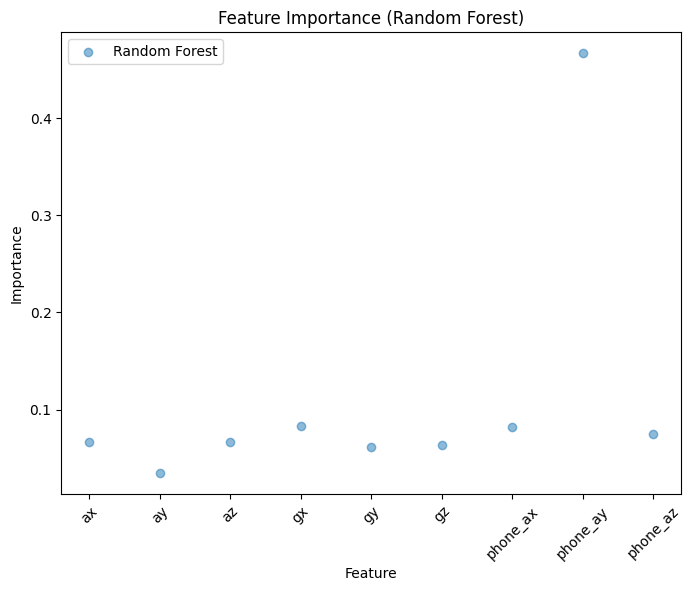

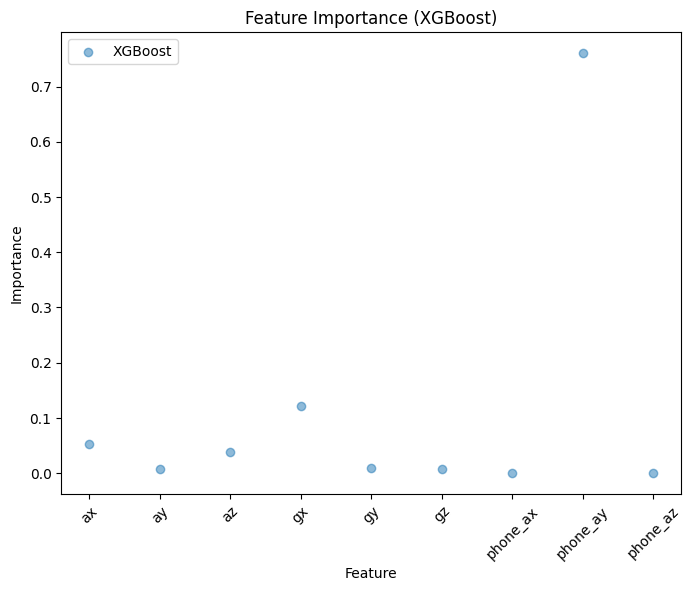

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 1]


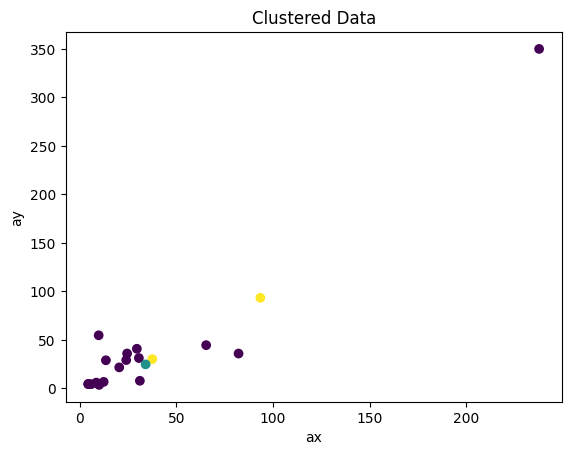

In [9]:
df=data2dataframe(dir_traces_train,windows_start,windows_end)#files2dataframe(filenames_train[windows_start:windows_end])
df_test=data2dataframe(dir_traces_test,windows_start,windows_end)#files2dataframe(filenames_test[windows_start:windows_end])
df_example=data2dataframe(dir_traces_example,windows_start,windows_end)#files2dataframe(filenames_test[windows_start:windows_end])

print("print data set for train")
print(df)
print("print data set for test")
print(df_test)
print("print data example")
print(df_example)

# Initialize K-means with the number of clusters corresponding to the number of sensor positions
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit K-means to the data
kmeans.fit(df)

cluster_centers = kmeans.cluster_centers_

# Display cluster centers
print("Cluster Centers:")
print(cluster_centers)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each point
ax.scatter(df["ax"], df["ay"], df["az"], c=kmeans.labels_, cmap='viridis', label='Data Points')
# Scatter plot for cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='x', c='red', s=300, label='Cluster Centers')

ax.set_xlabel('ax')
ax.set_ylabel('ay')
ax.set_zlabel('az')

plt.title('Cluster Centers in 3D a')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df["gx"], df["gy"], df["gz"], c=kmeans.labels_, cmap='viridis', label='Data Points')
# Scatter plot for cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='x', c='red', s=300, label='Cluster Centers')

ax.set_xlabel('gx')
ax.set_ylabel('gy')
ax.set_zlabel('gz')

plt.title('Cluster Centers in 3D g')
plt.legend()
plt.show()

# Calculate pairwise distances between cluster centers
distances = np.linalg.norm(cluster_centers[:, np.newaxis] - cluster_centers[np.newaxis, :], axis=-1)
means = np.mean(cluster_centers, axis=0)
std_devs = np.std(cluster_centers, axis=0)
ratio = cluster_centers[:, 1] / cluster_centers[:, 0]

# Plot pairwise distances between cluster centers
plt.figure(figsize=(8, 6))
plt.imshow(distances, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Pairwise distances between cluster centers')
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Index')
plt.show()

# Plot mean and standard deviation of cluster center coordinates
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(means)), means, yerr=std_devs, capsize=5)
plt.title('Mean and Standard Deviation of Cluster Center Coordinates')
plt.xlabel('Coordinate Index')
plt.ylabel('Value')
plt.xticks(np.arange(len(means)), ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'phone_ax', 'phone_ay', 'phone_az'], rotation=45)
plt.show()

# Plot ratio of coordinates between different dimensions
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(ratio)), ratio)
plt.title('Ratio of Coordinates between Different Dimensions')
plt.xlabel('Cluster Index')
plt.ylabel('Ratio')
plt.xticks(np.arange(len(ratio)), ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.show()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgboost = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)


# Fit models to the data and extract features
rf.fit(df, df_test)
xgboost.fit(df, df_test)


# Extract features from models
rf_features = rf.feature_importances_
xgboost_features = xgboost.feature_importances_
print(rf_features,xgboost_features)


# Plot cluster centers in 3D for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'phone_ax', 'phone_ay', 'phone_az'], rf_features, marker='o', label='Random Forest', alpha=0.5)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot cluster centers in 3D for XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'phone_ax', 'phone_ay', 'phone_az'], xgboost_features, marker='o', label='XGBoost', alpha=0.5)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.legend()
plt.show()

clusters = kmeans.fit_predict(df)
print(clusters)
#cluster labeling
labels = [0,1,2]# (0: left wrist, 1: belt/waistband, 2: right ankle)

# Add cluster labels to the DataFrame
df['cluster'] = [labels[i] for i in clusters]

# Visualize the results (replace this with your preferred visualization method)
plt.scatter(df['ax'], df['ay'], c=clusters, cmap='viridis')
plt.xlabel('ax')
plt.ylabel('ay')
plt.title('Clustered Data')
plt.show()


### dimencional reduction to 2D

print data set for train
           ax         ay
0    4.356494   4.505244
1    5.982555   4.479691
2   30.588148  31.375869
3   10.001328   3.675685
4    4.448040   4.723045
..        ...        ...
60  32.648095   9.838353
61   6.447924   5.622671
62  25.952692   9.005381
63  29.411874  60.088197
64   4.806803   9.513383

[65 rows x 2 columns]
print data set for test
           ax         ay
0    4.356494   4.505244
1    5.982555   4.479691
2   30.588148  31.375869
3   10.001328   3.675685
4    4.448040   4.723045
5   29.545345  40.925715
6   12.367845   6.821092
7    8.568319   6.094357
8   20.407074  21.745872
11  13.525226  29.072835
12  65.398925  44.661149
13  24.478724  36.057034
14  37.530733  30.293001
15  24.019845  29.274676
16   9.775467  54.821796
18  31.092221   7.924749
19  34.077321  24.838425
20  21.253684  32.243048
21   5.844662   5.295814
22   6.746958   6.746958
23   6.771313   6.721668
24  30.798637  66.196159
25  28.121049  33.437355
26  25.056921   6.832870
27 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


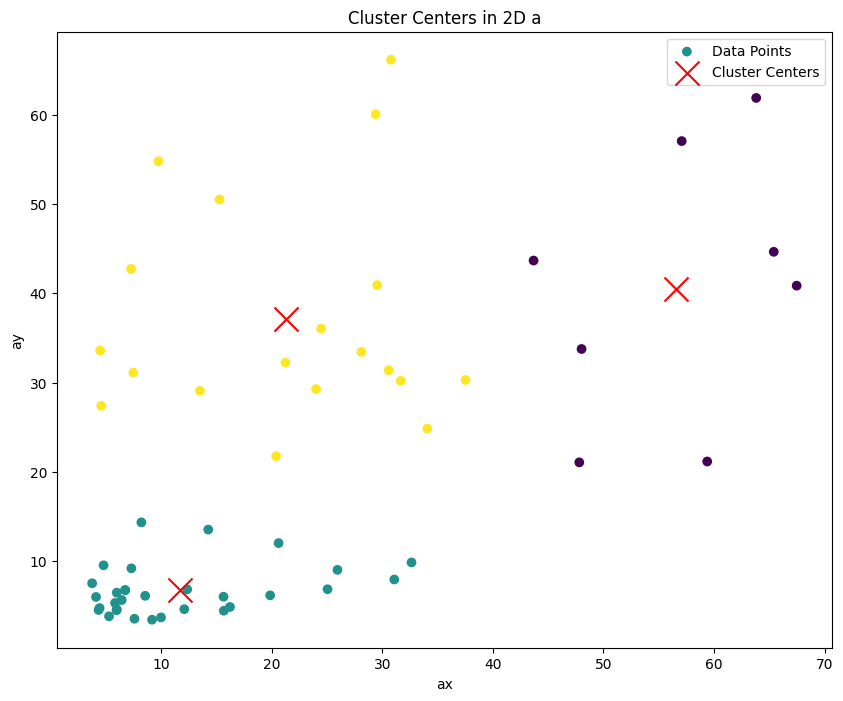

clusters
[1 1 2 1 1 2 1 1 2 2 0 2 2 2 2 1 2 2 1 1 1 2 2 1 1 0 1 0 0 1 1 0 1 1 1 1 2
 1 0 1 2 1 1 1 1 2 1 2 1 0 2 0 2 1 1 1 2 1]
[97.1035918989733, 18.42352286862559, 58.438067235915526]
case4
{1: 31, 2: 19, 0: 8}
[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0]
{0: 31, 1: 19, 2: 8}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
subset_df=data2dataframe(dir_traces_train,0,65,printbool=False,cols=cols_reduccion,sample_comlumn=False)#files2dataframe(filenames_train[windows_start:windows_end])
#subset_df_test=data2dataframe(dir_traces_test,windows_start,windows_end,cols=cols_reduccion,sample_comlumn=True)#files2dataframe(filenames_test[windows_start:windows_end])
#subset_df_example=data2dataframe(dir_traces_example,windows_start,windows_end,cols=cols_reduccion,sample_comlumn=True)#files2dataframe(filenames_test[windows_start:windows_end])


#print(subset_df,subset_df_test,subset_df_example)


try:
    print("print data set for train")
    print(subset_df)
    print("print data set for test")
    print(subset_df_test)
    print("print data example")
    print(subset_df_example)
except:
    pass

# Initialize K-means with the number of clusters corresponding to the number of sensor positions
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#samplerate=np.mean(subset_df['samplerate'])

#cleardata2(aceleration,samplerate)
#subset_df['ax'] = cleardata2(subset_df['ax'], samplerate)
#subset_df['ay'] = cleardata2(subset_df['ay'], samplerate)
        
subset_df = subset_df[subset_df['ay'] <= 80]
subset_df = subset_df[subset_df['ax'] <= 80]

subset_df_selected = subset_df.loc[:, cols_reduccion]
print(subset_df_selected)
# Fit K-means to the data
kmeans.fit(subset_df_selected)

cluster_centers = kmeans.cluster_centers_

# Display cluster centers
print("Cluster Centers:")
print(cluster_centers)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Scatter plot for each point
ax.scatter(subset_df["ax"], subset_df["ay"], c=kmeans.labels_, cmap='viridis', label='Data Points')
# Scatter plot for cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', s=300, label='Cluster Centers')

ax.set_xlabel('ax')
ax.set_ylabel('ay')

plt.title('Cluster Centers in 2D a')
plt.legend()
plt.show()

clusters = kmeans.fit_predict(subset_df)
print("clusters")
print(clusters)

def count_elements(arr):
    element_count = {}
    for element in arr:
        if element in element_count:
            element_count[element] += 1
        else:
            element_count[element] = 1
    return element_count

#we see the generation is of the number with his center is random, we made a function of calibrate this in order of hight value of acelerometer is the Right ankle and the low value acelerometer is the belt
transcription=calibrate(cluster_centers)
predict_clear=[]

print(count_elements(clusters))
for i in clusters:
    predict_clear.append(transcription[i])

print(predict_clear)
print(count_elements(predict_clear))



### dimencional reduction to 3D

In [18]:
cols_reduccion=["ax","ay","az"]

subset_df=data2dataframe(dir_traces_train,0,395,printbool=False,cols=cols_reduccion,sample_comlumn=False)#files2dataframe(filenames_train[windows_start:windows_end])
#subset_df_test=data2dataframe(dir_traces_test,windows_start,windows_end,cols=cols_reduccion,sample_comlumn=False)#files2dataframe(filenames_test[windows_start:windows_end])
#subset_df_example=data2dataframe(dir_traces_example,windows_start,windows_end,cols=cols_reduccion,sample_comlumn=False)#files2dataframe(filenames_test[windows_start:windows_end])

try:
    print("print data set for train")
    print(subset_df)
    print("print data set for test")
    print(subset_df_test)
    print("print data example")
    print(subset_df_example)
except:
    pass
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
subset_df = subset_df[subset_df['ax'] <= 120]
subset_df = subset_df[subset_df['ay'] <= 120]
subset_df = subset_df[subset_df['az'] <= 120]

subset_df_selected = subset_df.loc[:, cols_reduccion]


# Fit K-means to the data
kmeans.fit(subset_df_selected)

cluster_centers = kmeans.cluster_centers_

# Display cluster centers
print("Cluster Centers:")
print(cluster_centers)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each point
ax.scatter(subset_df["ax"], subset_df["ay"], subset_df["az"], c=kmeans.labels_, cmap='viridis', label='Data Points')
# Scatter plot for cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='x', c='red', s=300, label='Cluster Centers')

ax.set_xlabel('ax')
ax.set_ylabel('ay')
ax.set_zlabel('az')

plt.title('Cluster Centers in 3D a')
plt.legend()
plt.show()


clusters = kmeans.fit_predict(subset_df)
print("clusters")
print(clusters)
#we see the generation is of the number with his center is random, we made a function of calibrate this in order of hight value of acelerometer is the Right ankle and the low value acelerometer is the belt
transcription=calibrate(cluster_centers)
predict_clear=[]
for i in clusters:
    predict_clear.append(transcription[i])

print(predict_clear)


# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(subset_df_selected, kmeans.labels_)

# Plot silhouette scores
fig, ax = plt.subplots()
y_lower = 10
for i in range(num_clusters):
    # Aggregate silhouette scores for samples in cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / num_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute new y_lower for the next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("Silhouette plot for various clusters")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

KeyboardInterrupt: 

# gyroscope and accelerometer

In [ ]:
dir_traces_train = '/kaggle/input/24-exercise2/data/train'
def butter(f_s):
    # cut_off frequency
    cut_off = 10
    cut_off_ny = cut_off / (f_s / 2)
    b, a = scs.butter(2, cut_off_ny, btype='lowpass', fs=f_s)
    return b, a

def velocity_single(ax, ay, az, f_s):
    b, a = butter(f_s)
    ax_filt = scs.filtfilt(b, a, [ax])[0]
    ay_filt = scs.filtfilt(b, a, [ay])[0]
    az_filt = scs.filtfilt(b, a, [az])[0]

    dt = 1 / f_s
    vel_x = (ax_filt - np.mean(ax_filt)) * dt
    vel_y = (ay_filt - np.mean(ay_filt)) * dt
    vel_z = (az_filt - np.mean(az_filt)) * dt
    speed = np.sqrt(vel_x**2 + vel_y**2 + vel_z**2)
    return speed

def cleardata(value):
    f_s= value.samplerate
    dt = 1 / f_s
    total_samples = value.samplerate*value.total_time
    delta_v = int(total_samples * value.max_update_gap)
    aceleration=delta_v / value.total_time
    return aceleration

def files2dataframe_acelerometer_gyroscope(filenames):

    filedata=[]
    data_list = {"acelerometer":[],"gyroscope":[]}
    recordingOne=None
    for filename in range(len(filenames)):
        ax=0
        ay=0
        az=0
        gx=0
        gy=0
        gz=0
        asr=0
        gsr=0
        recording = Recording(filenames[filename])
        data = recording.data
        if filename==0:
            recordingOne=data 
        for key, value in data.items():
            if key=="ax":
                asr=value.samplerate
                ax=cleardata(value)
            elif key=="ay":
                ay=cleardata(value)
            elif key=="az":
                az=cleardata(value)
            elif key=="gx":
                gx=cleardata(value)
                gsr=value.samplerate
            elif key=="gy":
                gy=cleardata(value)
            elif key=="gz":
                gz=cleardata(value)
        a_speed=velocity(ax, ay, az, asr)
        g_speed=velocity(ax, ay, az, gsr)
        print(a_speed)
        data_list["acelerometer"].append(a_speed)              
        data_list["gyroscope"].append(g_speed)              


    df = pd.DataFrame(data_list)
    return df

def data2dataframe_acelerometer_gyroscope(dir_traces,windows_start,windows_end):
    filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
    filenames.sort()

    return files2dataframe_acelerometer_gyroscope(filenames[windows_start:windows_end])



subset_df=data2dataframe_acelerometer_gyroscope(dir_traces_train,0,15)#files2dataframe(filenames_train[windows_start:windows_end])
print(subset_df)


In [ ]:
high_threshold = 0.8  # Adjust as needed
low_threshold = 0.2   # Adjust as needed

# Initialize an empty list to store cluster labels
cluster_labels = []

# Iterate through each cluster centroid
for centroid in clusters:
    # Extract y and z coordinates of the centroid
    y, z = centroid
    
    # Check if the centroid is near "Right ankle" (high values)
    if y > high_threshold and z > high_threshold:
        label = "Right ankle"
    # Check if the centroid is near "Belt/waistband" (low values)
    elif y < low_threshold and z < low_threshold:
        label = "Belt/waistband"
    # For centroids between "Belt/waistband" and "Right ankle"
    else:
        # Calculate the distance from the centroid to the mid-point between "Belt/waistband" and "Right ankle"
        dist_to_belt = np.sqrt((y - low_threshold)**2 + (z - low_threshold)**2)
        dist_to_ankle = np.sqrt((y - high_threshold)**2 + (z - high_threshold)**2)
        # Assign label based on the closer distance
        if dist_to_belt < dist_to_ankle:
            label = "Belt/waistband"
        else:
            label = "Right ankle"
    
    # Append the label to the list of cluster labels
    cluster_labels.append(label)

# Print or use the cluster labels as needed
print(cluster_labels)

In [ ]:
center=[[9.55283045 ,1.14388754 ,7.77712208]
 ,[74.99272202, 58.86934602, 25.80814915],[31.57368712, 40.84183476, 13.84966334]]


# Submmision code

In [ ]:
# Loop through all filenames to process recordings
submission = []
for filename in filenames:
    recording = Recording(filename)

    # Assumes filename format ends with a three-digit ID before ".pkl"
    match = re.search(r'(\d{3})\.pkl$', filename)
    if match:
        id = int(match.group(1))
    else:
        raise ValueError(f'Filename {filename} does not match expected format')

    # Placeholder for the algorithm to process the recording
    # Implement the logic to infer watch location, path index, step count,
    # and activities (standing, walking, running, cycling) here.
    # Ensure your algorithm is tolerant to missing data and does not crash
    # when optional smartphone data traces are missing.

    path_idx = 0  # Integer, path in {0, 1, 2, 3, 4}
    watch_loc = 0  # Integer, 0: left wrist, 1: belt, 2: right ankle
    standing = False  # Boolean, True if participant was standing still throughout the recording
    walking = False  # Boolean, True if participant was walking throughout the recording
    running = False  # Boolean, True if participant was running throughout the recording
    cycling = False  # Boolean, True if participant was cycling throughout the recording
    step_count = 0  # Integer, number of steps, must be provided for each recording

    predictions = {
        'Id': id,
        'watch_loc': watch_loc,
        'path_idx': path_idx,
        'standing': standing,
        'walking': walking,
        'running': running,
        'cycling': cycling,
        'step_count': step_count
        }

    submission.append(predictions)

In [ ]:
# Write the predicted values into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using a text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns of the .csv file ("Id", "watch_loc", "path_idx", "standing", "walking", "running", "cycling", "step_count")
submission_df = pd.DataFrame(submission, columns=['Id', 'watch_loc', 'path_idx', 'standing', 'walking', 'running', 'cycling', 'step_count'])
submission_df.to_csv('/kaggle/working/submission.csv', index=False)